In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import selfies as sf
import exmol
from dataclasses import dataclass
from rdkit.Chem.Draw import rdDepictor

rdDepictor.SetPreferCoordGen(True)
sns.set_context("notebook")
sns.set_style(
    "dark",
    {
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.color": "#666666",
        "ytick.color": "#666666",
        "axes.edgecolor": "#666666",
        "axes.linewidth": 0.8,
        "figure.dpi": 300,
    },
)
color_cycle = ["#1BBC9B", "#F06060", "#5C4B51", "#F3B562", "#6e5687"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color_cycle)
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
np.random.seed(0)



2021-10-19 14:49:22.352403: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# scramble them
# Reduced for CI!
soldata = soldata.sample(frac=1, random_state=0).reset_index(drop=True)
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,B-4206,diuron,InChI=1S/C9H10Cl2N2O/c1-13(2)9(14)12-6-3-4-7(1...,XMTQQYYKAHVGBJ-UHFFFAOYSA-N,CN(C)C(=O)Nc1ccc(Cl)c(Cl)c1,-3.744300,1.227164,5,G4,233.098,...,1.0,76.0,1.0,0.0,0.0,1.0,32.34,92.603980,2.781208,352.665233
1,F-988,7-(3-amino-3-methylazetidin-1-yl)-8-chloro-1-c...,InChI=1S/C17H17ClFN3O3/c1-17(20)6-21(7-17)14-1...,DUNZFXZSFJLIKR-UHFFFAOYSA-N,CC1(N)CN(C2=C(Cl)C3=C(C=C2F)C(=O)C(C(=O)O)=CN3...,-5.330000,0.000000,1,G1,365.792,...,3.0,132.0,2.0,2.0,2.0,4.0,88.56,147.136366,2.001398,973.487509
2,C-1996,4-acetoxybiphenyl; 4-biphenylyl acetate,InChI=1S/C14H12O2/c1-11(15)16-14-9-7-13(8-10-1...,MISFQCBPASYYGV-UHFFFAOYSA-N,CC(=O)OC1=CC=C(C=C1)C2=CC=CC=C2,-4.400000,0.000000,1,G1,212.248,...,2.0,80.0,2.0,0.0,0.0,2.0,26.30,94.493449,2.228677,471.848345
3,A-3055,methane dimolybdenum,InChI=1S/CH4.2Mo/h1H4;;,JAGQSESDQXCFCH-UHFFFAOYSA-N,C.[Mo].[Mo],-3.420275,0.409223,2,G3,207.923,...,0.0,20.0,0.0,0.0,0.0,0.0,0.00,49.515427,-0.000000,2.754888
4,A-2575,ethyl 4-[[(methylphenylamino)methylene]amino]b...,InChI=1S/C17H18N2O2/c1-3-21-17(20)14-9-11-15(1...,GNGYPJUKIKDJQT-UHFFFAOYSA-N,CCOC(=O)c1ccc(cc1)N=CN(C)c2ccccc2,-5.450777,0.000000,1,G1,282.343,...,5.0,108.0,2.0,0.0,0.0,2.0,41.90,124.243431,2.028889,606.447052


In [3]:
selfies_list = [sf.encoder(exmol.sanitize_smiles(s)[1]) for s in soldata.SMILES]

In [4]:
basic = set(exmol.get_basic_alphabet())
data_vocab = set(sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None]))
vocab = ['[Nop]']
vocab.extend(list(data_vocab.union(basic)))
vocab_stoi = {o:i for o,i in zip(vocab, range(len(vocab)))}
#vocab_stoi['[nop]'] = 0 

def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token == '.':
            continue #?
        if token in vocab_stoi:
            result.append(vocab_stoi[token])
        else:
            result.append(np.nan)
            #print('Warning')
    return result

def ints2selfies(v):
    return ''.join([vocab[i] for i in v])

# test them out
s = selfies_list[0]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
assert so == s.replace('.','') #make sure '.' is removed from Selfies string during assertion

selfies: [C][N][Branch1_1][C][C][C][Branch1_2][C][=O][N][C][=C][C][=C][Branch1_1][C][Cl][C][Branch1_1][C][Cl][=C][Ring1][Branch2_1]
selfies2ints: [92, 4, 48, 92, 92, 92, 145, 92, 130, 4, 92, 113, 92, 113, 48, 92, 143, 92, 48, 92, 143, 113, 128, 112]
ints2selfes: [C][N][Branch1_1][C][C][C][Branch1_2][C][=O][N][C][=C][C][=C][Branch1_1][C][Cl][C][Branch1_1][C][Cl][=C][Ring1][Branch2_1]


In [5]:
vocab_stoi

{'[Nop]': 0,
 '[Niexpl]': 1,
 '[Yexpl]': 2,
 '[#O+expl]': 3,
 '[N]': 4,
 '[Csexpl]': 5,
 '[NH+expl]': 6,
 '[=Pbexpl]': 7,
 '[Pt+4expl]': 8,
 '[=C-expl]': 9,
 '[Br-expl]': 10,
 '[Branch2_3]': 11,
 '[=Cuexpl]': 12,
 '[=Yexpl]': 13,
 '[Mgexpl]': 14,
 '[Seexpl]': 15,
 '[Pexpl]': 16,
 '[Fe+3expl]': 17,
 '[Ring3]': 18,
 '[B-expl]': 19,
 '[NH4+expl]': 20,
 '[CaH2expl]': 21,
 '[Bi+3expl]': 22,
 '[Taexpl]': 23,
 '[Hexpl]': 24,
 '[Biexpl]': 25,
 '[Coexpl]': 26,
 '[MgH2expl]': 27,
 '[Nd+3expl]': 28,
 '[#S]': 29,
 '[S]': 30,
 '[Cl-expl]': 31,
 '[Agexpl]': 32,
 '[=N+expl]': 33,
 '[OH-expl]': 34,
 '[Asexpl]': 35,
 '[Mo+2expl]': 36,
 '[NH3+expl]': 37,
 '[Al+3expl]': 38,
 '[=N]': 39,
 '[SH-expl]': 40,
 '[=Srexpl]': 41,
 '[Sr+2expl]': 42,
 '[Mg+2expl]': 43,
 '[Cexpl]': 44,
 '[S+expl]': 45,
 '[SH-2expl]': 46,
 '[Beexpl]': 47,
 '[Branch1_1]': 48,
 '[Auexpl]': 49,
 '[Ni+2expl]': 50,
 '[Gdexpl]': 51,
 '[Cl+3expl]': 52,
 '[Ring2]': 53,
 '[Sbexpl]': 54,
 '[Li+expl]': 55,
 '[Bexpl]': 56,
 '[Hgexpl]': 57,
 '[H

In [6]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
    hidden_dim: int


config = Config(
    vocab_size=len(vocab),
    example_number=len(selfies_list),
    batch_size=16,
    buffer_size=10000,
    embedding_dim=256,
    hidden_dim=128,
    rnn_units=128,
)

In [7]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post")

# Now build dataset
data = tf.data.Dataset.from_tensor_slices(
    (padded_seqs, soldata.Solubility.iloc[[bool(s) for s in selfies_list]].values)
)
# now split into val, test, train and batch
N = len(data)
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), nontest.skip(
    split
).shuffle(config.buffer_size).batch(config.batch_size).prefetch(
    tf.data.experimental.AUTOTUNE
)

2021-10-19 14:49:27.873827: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 14:49:27.874551: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 14:49:27.943984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 14:49:27.944587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 750 Ti computeCapability: 5.0
coreClock: 1.15GHz coreCount: 5 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 80.47GiB/s
2021-10-19 14:49:27.944650: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 14:49:27.949335: I tensorflow/stream_executor/platform/def

In [8]:
padded_seqs[0]

array([ 92,   4,  48,  92,  92,  92, 145,  92, 130,   4,  92, 113,  92,
       113,  48,  92, 143,  92,  48,  92, 143, 113, 128, 112,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [9]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(
    tf.keras.layers.Embedding(
        input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True
    )
)

# RNN layer
model.add(tf.keras.layers.GRU(config.rnn_units))
# a dense hidden layer
model.add(tf.keras.layers.Dense(config.hidden_dim, activation="relu"))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         54528     
_________________________________________________________________
gru (GRU)                    (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 219,393
Trainable params: 219,393
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(tf.optimizers.Adam(1e-4), loss="mean_squared_error")
result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=2)
model.save("models/RNN-model")

Epoch 1/100


2021-10-19 14:49:30.781009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-19 14:49:30.807453: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3997845000 Hz
2021-10-19 14:49:31.056587: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-19 14:49:31.207812: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-19 14:49:31.366835: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


500/500 - 10s - loss: 4.9172 - val_loss: 2.8016
Epoch 2/100
500/500 - 6s - loss: 2.5301 - val_loss: 2.5142
Epoch 3/100
500/500 - 7s - loss: 2.2945 - val_loss: 2.5044
Epoch 4/100
500/500 - 7s - loss: 2.1832 - val_loss: 2.3571
Epoch 5/100
500/500 - 7s - loss: 2.1136 - val_loss: 2.3789
Epoch 6/100
500/500 - 7s - loss: 2.0719 - val_loss: 2.3362
Epoch 7/100
500/500 - 7s - loss: 2.0150 - val_loss: 2.2356
Epoch 8/100
500/500 - 7s - loss: 1.9579 - val_loss: 2.2315
Epoch 9/100
500/500 - 7s - loss: 1.9271 - val_loss: 2.2113
Epoch 10/100
500/500 - 7s - loss: 1.8964 - val_loss: 2.2220
Epoch 11/100
500/500 - 7s - loss: 1.8600 - val_loss: 2.1759
Epoch 12/100
500/500 - 7s - loss: 1.8144 - val_loss: 2.1934
Epoch 13/100
500/500 - 7s - loss: 1.7833 - val_loss: 2.1443
Epoch 14/100
500/500 - 7s - loss: 1.7378 - val_loss: 2.2386
Epoch 15/100
500/500 - 7s - loss: 1.7088 - val_loss: 2.1101
Epoch 16/100
500/500 - 7s - loss: 1.6731 - val_loss: 2.1518
Epoch 17/100
500/500 - 7s - loss: 1.6304 - val_loss: 2.0725


2021-10-19 15:00:36.685477: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/RNN-model/assets


INFO:tensorflow:Assets written to: models/RNN-model/assets


In [11]:
#model = tf.keras.models.load_model("models/RNN-model")

2021-10-19 14:04:58.268977: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-10-19 14:04:58.328160: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-10-19 14:04:58.339009: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 45 outputs. Output shapes may be inaccurate.
2021-10-19 14:04:58.506120: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2021-10-19 14:04:58.516277: W tensorflow/core/common_runtime/graph_constructor.cc:809] Node 'cond' has 4 outputs but the _output_sh

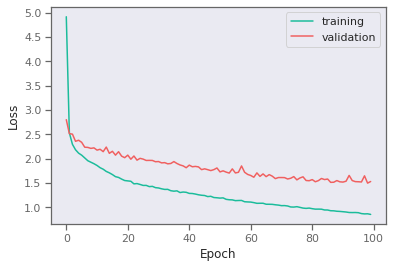

In [11]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

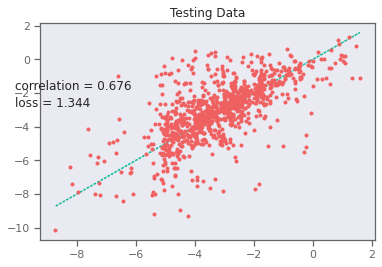

In [12]:
yhat = []
test_y = []
for x, y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

# plot test data
plt.plot(test_y, test_y, ":")
plt.plot(test_y, yhat, ".")
plt.text(min(y) - 7, max(y) - 2, f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}")
plt.text(min(y) - 7, max(y) - 3, f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}")
plt.title("Testing Data")
plt.savefig("rnn-fit.png", dpi=300)
plt.show()

## CF explanation:

In the following example let's say we would like our molecules to return a solubility value of -3.5. Here we use `counterstone` algorithm to create counter factual explanations. In other words, we would like to see what are the minimal mutations that could to be done to our input structure to get our desired solubility.

In [ ]:
def predictor_function(smile_list,selfies):
    encoded = [selfies2ints(s) for s in selfies]
    # check for nans
    valid = [1. if sum(e) > 0 else np.nan for e in encoded]
    encoded = [np.nan_to_num(e, nan=0) for e in encoded]
    padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')
    labels = np.reshape(model.predict(padded_seqs), (-1))
    return labels * valid

In [ ]:
predictor_function([], ['[C][#S-expl]', '[C]'])

In [ ]:
stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(), 'max_mutations': 2}
space = exmol.sample_space(soldata.SMILES[4], predictor_function, stoned_kwargs=stoned_kwargs)

In [ ]:
exps = exmol.rcf_explain(space, 0.5, nmols=4)

In [ ]:
fkw = {'figsize': (10,3)}
exmol.plot_cf(exps, figure_kwargs=fkw, mol_size=(450,400), nrows=1)
plt.savefig('rnn-simple.png',  bbox_inches='tight', dpi=180)

In [ ]:
fkw = {'figsize': (10,4)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

exmol.plot_space(space, exps, figure_kwargs=fkw, mol_size=(300,200), offset=1)
plt.colorbar(location='left', label='Solubility [Log M]')
plt.tight_layout()
plt.savefig('rnn-space.png', bbox_inches='tight', dpi=180)

In [ ]:
space = exmol.sample_space(soldata.SMILES[4], predictor_function, preset='wide')
exps = exmol.rcf_explain(space, 0.5)
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

exmol.plot_space(space, exps, figure_kwargs=fkw, mol_size=(200,200), offset=1)
plt.colorbar(location='left', label='Solubility [Log M]')
plt.tight_layout()
plt.savefig('rnn-wide.png', bbox_inches='tight', dpi=180)

## Figure showing effect of mutation number and Alphabet


In [ ]:
exps = []
spaces = []
for i in [1,3,5]:
    stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(),'min_mutations':i, 'max_mutations': i}
    space = exmol.sample_space(soldata.SMILES[4], predictor_function, stoned_kwargs=stoned_kwargs)
    spaces.append(space)
    e = exmol.rcf_explain(space, nmols=2)
    if len(exps) == 0:
        exps.append(e[0])
    for ei in e:
        if not ei.is_origin and 'Decrease' in ei.label:
            ei.label = f'Mutations = {i}'
            exps.append(ei)
            break

In [ ]:
fkw = {'figsize': (10, 4)}
exmol.plot_cf(exps, figure_kwargs=fkw, mol_fontsize=26, mol_size=(400,400), nrows=1)
plt.savefig('rnn-mutations.png', bbox_inches='tight', dpi=180)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(8,3), dpi=180, squeeze=True, sharey=True)
for i,n in enumerate([1,3,5]):
    axs[i].hist([e.similarity for e in spaces[i][1:]], bins=99,edgecolor='none')
    axs[i].set_title(f'Mutations = {n}')
    axs[i].set_xlim(0,1)
plt.tight_layout()
plt.savefig('rnn-mutation-hist.png', bbox_inches='tight', dpi=180)

In [ ]:
basic = exmol.get_basic_alphabet()
train = sf.get_alphabet_from_selfies(selfies_list)
wide = sf.get_semantic_robust_alphabet()

alphs = {'Basic': basic, 'Training Data': train, 'SELFIES': wide}

exps = []
for l,a in alphs.items():
    stoned_kwargs={'num_samples': 2500//2, 'alphabet':a, 'max_mutations': 2}
    space = exmol.sample_space(soldata.SMILES[4], predictor_function, stoned_kwargs=stoned_kwargs)
    e = exmol.rcf_explain(space, nmols=2)
    if len(exps) == 0:
        exps.append(e[0])
    for ei in e:
        if not ei.is_origin and 'Decrease' in ei.label:
            ei.label = f'Alphabet = {l}'
            exps.append(ei)
            break

In [ ]:
fkw = {'figsize': (10, 4)}
exmol.plot_cf(exps, figure_kwargs=fkw, mol_fontsize=26, mol_size=(400,400), nrows=1)
plt.savefig('rnn-alphabets.png', bbox_inches='tight', dpi=180)

## Shapley Explanation

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
print(np.shape(soldata))
print(np.shape(selfies_list))
print(np.shape(encoded))
print(len(data))
print(np.shape(train_data))

In [ ]:
vocab_stoi_2 = vocab_stoi.copy()
vocab_stoi_2['[nop]'] = len(vocab_stoi_2)
print(vocab_stoi)
print(vocab_stoi_2)

In [ ]:
selfies_symbol_counts = {'[nop]': 0}

for s in  selfies_list:
    for token in sf.split_selfies(s):
        if token == '.':
            continue #?
        if token in selfies_symbol_counts:
            selfies_symbol_counts[token] += 1
        else:
            selfies_symbol_counts[token] = 0

print(selfies_symbol_counts)
print(len(selfies_symbol_counts))
print()
# print out tokens
sorted_token_counts = list(sorted(selfies_symbol_counts.items(), key=lambda i: -i[1]))
print(sorted_token_counts)
print(len(sorted_token_counts))
print()
token_counts = [x[1] for x in sorted(sorted_token_counts, key=lambda i: vocab_stoi_2[i[0]])]
print(token_counts)
print(len(token_counts))
print()
print(vocab_stoi_2)
print(len(vocab_stoi_2))

In [ ]:
prob_vector = np.array(token_counts, dtype=np.float64)
#print(prob_vector)
prob_vector /= np.sum(prob_vector)
print(prob_vector)

In [ ]:
print(train_data)
pred = np.reshape(model.predict(train_data),-1)
expec_val = np.sum(pred)/len(pred)
print(len(pred))
print(expec_val)

In [ ]:
def shapley(s, i, N, model):
    np.random.seed(0)
    # working in ints (not one hots)
    #print(s)
    
    # make N shuffled copies of s
    s_shuf = np.stack([s for i in range(N)])
    [np.random.shuffle(s_shuf[i]) for i in range(N)]
    #print(s_shuf)
    
    new_s = np.stack([np.argmax(np.random.multinomial(1, prob_vector, size=len(s)),axis=-1) for i in range(N)])
    s_p = new_s.copy()
    s_m = new_s.copy()
    #print(new_s)
    # set new_x[:] i to be x_i
    s_p[:,i] = s_shuf[:,i]
    #print(new_s)
    #print(s_p)
    #print(s_m)
    pad_s_p = tf.keras.preprocessing.sequence.pad_sequences(s_p, padding='post')
    pad_s_m = tf.keras.preprocessing.sequence.pad_sequences(s_m, padding='post')
    val_p = np.reshape(model.predict(pad_s_p), (-1))
    val_m = np.reshape(model.predict(pad_s_m), (-1))
    #print(val_p)
    #print(val_m)
    val_p_avg = np.sum(val_p)/N
    val_m_avg = np.sum(val_m)/N
    #print(val_p_avg)
    #print(val_m_avg)
    
    result = np.sum(val_p-val_m)/N
    #print(result)
    #print(result*val_p_avg)
    #print(result*val_m_avg)
    #print()
    
    return result #- expec_val

In [ ]:
seq = soldata.SMILES[10]
x = sf.encoder(seq)
s = selfies2ints(x)
i = 2
N_samples = 1000
model = model

print(seq)
print(x)
print(s)
print()

#shap = shapley(s,i,N_samples,model)
#print(shap)

shap_val = [shapley(s,f,N_samples,model) for f in range(len(s))]
print("shapley values (SV): ", shap_val)
print()
print("Sum of SV: ", np.sum(shap_val))
print("Avg(f): ", expec_val)
padded_seq = tf.keras.preprocessing.sequence.pad_sequences([s], padding='post')
label =  np.reshape(model.predict(padded_seq), (-1))[0]
print("f[s]: ", label)
print("f(x) - Avg(f): ", label - expec_val)

In [ ]:
val = []
ms = [2, 5, 10, 100, 500, 1200, 2500, 5000]
print(ms)
for m in ms:
    val_m = np.sum([shapley(s,f,m,model) for f in range(len(s))])
    val.append(val_m)

In [ ]:
print(val)

In [ ]:
val_t = [i+expec_val for i in val]

In [ ]:
plt.plot(ms, val_t, '-o', label='Sum of Shapley Values')
plt.axhline(label, color='C1', label=r'$\hat{f}\left(\vec{x}\right)$')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def plot_grad(g, s, ax=None):
    #g = np.array(g)
    if ax is None:
        plt.figure()
        ax = plt.gca()
    if len(g.shape) == 3:
        h = g[0, np.arange(len(s)), list(map(ALPHABET.index,s))]
    else:
        h = g
    ax.bar(np.arange(len(s)), height=h)
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels(s)

In [ ]:
print(np.array(shap_val))
print(list(sf.split_selfies(x)))
print(s)
plot_grad(np.array(shap_val), s)
plt.show()

## Shapley More

In [ ]:
import itertools

In [ ]:
# make a dictonary of all possible groupings with N from vocab

N = 2 #<----- 

# using the vocab without '[nop]'' because making combinations with it does not make sense

#vocab_n = list(itertools.permutations(list(vocab_stoi.keys()), N))

vocab_n = list(itertools.product(list(vocab_stoi.keys()), repeat=N))
vocab_n = [''.join(s) for s in vocab_n]
vocab_stoi_n = {o:i for o,i in zip(vocab_n, range(len(vocab_n)))}

# adding '[nop]' seperately
vocab_stoi_n['[nop]'] = len(vocab_stoi_n)

#print('len vocab_n:\n', len(vocab_n))
#print()
print('len vocab_stoi_n:\n', len(vocab_stoi_n))

In [ ]:
# function returns list with groupings of n

def nwise(iterable, n=1):
    iterators = itertools.tee(iterable, n)
    for i in range(n):
        for _ in range(i):
            next(iterators[i], None)
    return zip(*iterators)

In [ ]:
sample = list(sf.split_selfies(selfies_list[0]))
print(sample)
sample_n = [''.join(s) for s in list(nwise(sample,N))]

# handle "." here??
# sample_n = [s for s in sample_n if "." not in s]
print()
print(sample_n)
print()

#testing reverse list
sample_n += [''.join(list(s)[::-1]) for s in list(nwise(sample,N))]
print(sample_n)

In [ ]:
n_symbol_counts = {}

for s in selfies_list:
    s_list = list(sf.split_selfies(s))
    s_list_n = [''.join(s) for s in list(nwise(s_list,N))]
    #s_list_n += [''.join(list(s)[::-1]) for s in list(nwise(s_list,N))] <--- Account for token pairs in reverse ?
    for token in s_list_n:
            if '.' in token:
                continue #?
            if token in n_symbol_counts:
                n_symbol_counts[token] += 1
            else:
                n_symbol_counts[token] = 0

# replacing vocab with only those that actually occur                
n_symbol_counts['[nop]']=0
vocab_n = list(n_symbol_counts.keys())
vocab_stoi_n = {o:i for o,i in zip(vocab_n, range(len(vocab_n)))}
#vocab_stoi_n['[nop]'] = len(vocab_stoi_n)

#print(vocab_n)
print(len(vocab_n))
#print(vocab_stoi_n)
print(len(vocab_stoi_n))

print()
#print(n_symbol_counts)
print(len(n_symbol_counts))
print()
# print out tokens
sorted_n_token_counts = list(sorted(n_symbol_counts.items(), key=lambda i: -i[1]))
print(sorted_n_token_counts)
print(len(sorted_n_token_counts))
print()
n_token_counts = [x[1] for x in sorted(sorted_n_token_counts, key=lambda i: vocab_stoi_n[i[0]])]
print(n_token_counts)
print(len(n_token_counts))




In [ ]:
n_prob_vector = np.array(n_token_counts, dtype=np.float64)
#print(prob_vector)
n_prob_vector /= np.sum(n_prob_vector)
print(n_prob_vector[:20])
print(len(n_prob_vector))

In [ ]:
# Does not handle selfies of odd length!!
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
def selfies2ints_n(s):
    result = []
    s_list = list(sf.split_selfies(s))
    s_list_n = ["".join(s) for s in list(chunks(s_list,N))]
    for token in s_list_n:
        if '.' in token:
            continue #?
        if token in vocab_stoi_n:
            result.append(vocab_stoi_n[token])
        else:
            result.append(np.nan)
            #print('Warning')
    return result

def ints2selfies_n(v):
    return ''.join([vocab_n[i] for i in v])


s = selfies_list[10]
s2i = selfies2ints_n(s)
i2s = ints2selfies_n(s2i)
print(s)
print(s2i)
print(i2s)

In [ ]:
def shapley_n(s, i, N, model):
    np.random.seed(0)
    # smaple features
    # working in ints (not one hots)
    new_s = np.stack([np.argmax(np.random.multinomial(1, n_prob_vector, size=len(s)),axis=-1) for i in range(N)])
    s_p = new_s.copy()
    s_m = new_s.copy()
    #print(new_s)
    # set new_x[:] i to be x_i
    s_p[:,i] = s[i]
    #print(new_s)
    #print(s_p)
    #print(s_m)
    
    # Convert back to non-group for model
    
    # get selfies
    s_p = [ ints2selfies_n(s) for s in s_p ]
    s_m = [ ints2selfies_n(s) for s in s_m ]
    #print()
    #print(s_p)
    #print(s_m)
    
    # get non_group ints
    s_p = [ selfies2ints(s) for s in s_p ]
    s_m = [ selfies2ints(s) for s in s_m ]
    #print()
    #print(s_p)
    #print(s_m)
    
    pad_s_p = tf.keras.preprocessing.sequence.pad_sequences(s_p, padding='post')
    pad_s_m = tf.keras.preprocessing.sequence.pad_sequences(s_m, padding='post')
    val_p = np.reshape(model.predict(s_p), (-1))
    val_m = np.reshape(model.predict(s_m), (-1))
    #print(val_p)
    #print(val_m)
    val_p_avg = np.sum(val_p)/N
    val_m_avg = np.sum(val_m)/N
    #print(val_p_avg)
    #print(val_m_avg)
    
    result = np.sum(val_p-val_m)/N
    #print(result)
    #print(result*val_p_avg)
    #print(result*val_m_avg)
    #print()
    
    return result #- expec_val

In [ ]:
seq = soldata.SMILES[10]
x = sf.encoder(seq)
s = selfies2ints_n(x)
i = 2
N_samples = 2000
model = model

print(seq)
print(x)
print(s)
print()

#shap = shapley_n(s,i,N_samples,model)
#print(shap)

shap_val = [shapley_n(s,f,N_samples,model) for f in range(len(s))]
print("shapley values (SV): ", shap_val)
print("Sum of SV: ", np.sum(shap_val))
padded_seq = tf.keras.preprocessing.sequence.pad_sequences([selfies2ints(x)], padding='post')
label =  np.reshape(model.predict(padded_seq), (-1))[0]
print("f[s]: ", label)

In [ ]:
val = []
ms = [5, 10, 100, 500, 1200, 2500, 5000]
print(ms)
for m in ms:
    val_m = np.sum([shapley(s,f,m,model) for f in range(len(s))])
    val.append(val_m)

In [ ]:
print(val)
plt.plot(ms, val, '-o', label='Sum of Shapley Values')
plt.axhline(label, color='C1', label=r'$\hat{f}\left(\vec{x}\right)$')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(np.array(shap_val))
#print(list(sf.split_selfies(x)))
print()
print(["".join(s) for s in list(chunks(list(sf.split_selfies(x)),N))])
print()
print(s)
plot_grad(np.array(shap_val), s)
plt.show()

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import tensorflow as tf
import selfies as sf
import exmol
from dataclasses import dataclass
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
soldata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index('MolWt')
np.random.seed(0)

In [ ]:
# scramble them
# Reduced for CI!
soldata = soldata.sample(frac=0.01, random_state=0).reset_index(drop=True)
soldata.head()

In [ ]:
selfies_list = [sf.encoder(exmol.sanitize_smiles(s)[1]) for s in soldata.SMILES]

In [ ]:
vocab = list(sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None]))
vocab_stoi = {o:i for o,i in zip(vocab, range(len(vocab)))}
print('Vocab size', len(vocab))

def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token == '.':
            continue #?
        if token in vocab_stoi:
            result.append(vocab_stoi[token])
        else:
            result.append(np.nan)
            #print('Warning')
    return result
def ints2selfies(v):
    return ''.join([vocab[i] for i in v])

# test them out
s = selfies_list[0]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
assert so == s

In [ ]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
    hidden_dim: int
        
config = Config(vocab_size=len(vocab), 
                example_number=len(selfies_list), 
                batch_size=16, 
                buffer_size=10000, 
                embedding_dim=256, 
                hidden_dim=128,
                rnn_units=128)

In [ ]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')

# Now build dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, soldata.Solubility.iloc[[bool(s) for s in selfies_list]].values))
# now split into val, test, train and batch
N = len(data)  
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True))

# RNN layer
model.add(tf.keras.layers.GRU(config.rnn_units))
# a dense hidden layer
model.add(tf.keras.layers.Dense(config.hidden_dim, activation='relu'))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

In [ ]:
model.compile(tf.optimizers.Adam(1e-4), loss='mean_squared_error')
result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=0)

In [ ]:
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
yhat = []
test_y = []
for x,y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

# plot test data
plt.plot(test_y, test_y, ':')
plt.plot(test_y, yhat, '.')
plt.text(min(y) - 7, max(y) - 2, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(min(y) - 7, max(y) - 3, f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.title('Testing Data')
plt.savefig('rnn-fit.png', dpi=300)
plt.show()


## Shapley Explanation

In [ ]:
import itertools

In [ ]:
def nwise(iterable, n=1):
    iterators = itertools.tee(iterable, n)
    for i in range(n):
        for _ in range(i):
            next(iterators[i], None)
    return zip(*iterators)

In [ ]:
sample = list(sf.split_selfies(selfies_list[0]))
print(sample)
print()
print(list(nwise(sample,1)))
print()
print([''.join(s) for s in list(nwise(sample,1))])
print()
print(list(nwise(sample,2)))
print()
print([''.join(s) for s in list(nwise(sample,2))])
print()
print(list(nwise(sample,3)))
print()
print([''.join(s) for s in list(nwise(sample,3))])

In [ ]:
symbol_counts_1 = {}
symbol_counts_2 = {}
symbol_counts_3 = {}

for n in [1,2,3]:
    if n == 1: 
        n_symbol_counts = symbol_counts_1
    elif n == 2: 
        n_symbol_counts = symbol_counts_2
    elif n == 3: 
        n_symbol_counts = symbol_counts_3
        
    for s in selfies_list:
        #print(s)
        s_list = list(sf.split_selfies(s))    
        s_list_n = [''.join(s) for s in list(nwise(s_list,n))]
        #s_list_n += [''.join(list(s)[::-1]) for s in list(nwise(s_list,N))] <--- Account for token pairs in reverse ?
        for token in s_list_n:
                if '.' in token:
                    continue #?
                if token in n_symbol_counts:
                    n_symbol_counts[token] += 1
                else:
                    n_symbol_counts[token] = 1
                    
#print(symbol_counts_1)
#print()
#print(symbol_counts_2)
#print()
#print(symbol_counts_3)
#print()

symbol_counts_1 = dict(sorted(symbol_counts_1.items(), key=lambda i: -i[1]))
symbol_counts_2 = dict(sorted(symbol_counts_2.items(), key=lambda i: -i[1]))
symbol_counts_3 = dict(sorted(symbol_counts_3.items(), key=lambda i: -i[1]))
#print(symbol_counts_1)
#print()
print(symbol_counts_2)
print()
#print(symbol_counts_3)
#print()


vocab_1 = list(symbol_counts_1.keys())
vocab_stoi_1 = {o:i for o,i in zip(vocab_1, range(len(vocab_1)))}
vocab_2 = list(symbol_counts_2.keys())
vocab_stoi_2 = {o:i for o,i in zip(vocab_2, range(len(vocab_2)))}
vocab_3 = list(symbol_counts_3.keys())
vocab_stoi_3 = {o:i for o,i in zip(vocab_3, range(len(vocab_3)))}
#print(vocab_1)
#print(vocab_stoi_1)
#print()
print(vocab_2)
print(vocab_stoi_2)
print()
#print(vocab_3)
#print(vocab_stoi_3)
#print()


In [ ]:
symbol_counts_all = symbol_counts_1 | symbol_counts_2 | symbol_counts_3
symbol_counts_all = dict(sorted(symbol_counts_all.items(), key=lambda i: -i[1]))

vocab_all = list(symbol_counts_all.keys())
vocab_stoi_all = {o:i for o,i in zip(vocab_all, range(len(vocab_all)))}

print(symbol_counts_all)
print(vocab_all)
print(vocab_stoi_all)

In [ ]:
counts_1 = list(symbol_counts_1.values())
counts_2 = list(symbol_counts_2.values())
counts_3 = list(symbol_counts_3.values())
counts_all = list(symbol_counts_all.values())
#print(counts_1)
#print()
print(counts_2)
print()
#print(counts_3)
#print()
#print(counts_all)
#print()


prob_vector_1 = np.array(counts_1, dtype=np.float64)
prob_vector_1 /= np.sum(prob_vector_1)

prob_vector_2 = np.array(counts_2, dtype=np.float64)
prob_vector_2 /= np.sum(prob_vector_2)

prob_vector_3 = np.array(counts_3, dtype=np.float64)
prob_vector_3 /= np.sum(prob_vector_3)

prob_vector_all = np.array(counts_all, dtype=np.float64)
prob_vector_all /= np.sum(prob_vector_all)


#print(prob_vector_1)
#print()
print(prob_vector_2)
print()
#print(prob_vector_3)
#print()
#print(prob_vector_all)
#print()

In [ ]:
info_1 = {'vocab':vocab_1, 'vocab_stoi': vocab_stoi_1, 'symbol_counts': symbol_counts_1, 'prob_vector': prob_vector_1}
info_2 = {'vocab':vocab_2, 'vocab_stoi': vocab_stoi_2, 'symbol_counts': symbol_counts_2, 'prob_vector': prob_vector_2}
info_3 = {'vocab':vocab_3, 'vocab_stoi': vocab_stoi_3, 'symbol_counts': symbol_counts_3, 'prob_vector': prob_vector_3}
info_all = {'vocab':vocab_all, 'vocab_stoi': vocab_stoi_all, 'symbol_counts': symbol_counts_all, 'prob_vector': prob_vector_all}

info = [info_1, info_2, info_3] #, info_all

In [ ]:
info[2]['vocab']

In [ ]:
def token2int(token, n):
    vocab_stoi_n = info[n-1]['vocab_stoi']
    if '.' in token:
            pass #?
    elif token in vocab_stoi_n:
        num = vocab_stoi_n[token]
    else:
        num = np.nan
    return num
    
def int2token(num, n):
    vocab_n = info[n-1]['vocab']        
    return vocab_n[num]
    
print(vocab_1[5])
print(token2int(vocab_1[5],1))
print(int2token(token2int(vocab_1[5],1),1))
print(vocab_2[5])
print(token2int(vocab_2[5],2))
print(int2token(token2int(vocab_2[5],2),2))
print(vocab_3[5])
print(token2int(vocab_3[5],3))
print(int2token(token2int(vocab_3[5],3),3))
#print(vocab_all[5])
#print(token2int(vocab_all[5],'all'))
#print(int2token(token2int(vocab_all[5],'all'),'all'))

In [ ]:
# Does not handle selfies of odd length!!
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
s_list = list(sf.split_selfies(selfies_list[5]))
print(s_list)
print(len(s_list))

#chunk list
cs_list = list(chunks(s_list,2))
print(cs_list)

#mod chunk list
mcs_list = [[''.join(s),len(s)] for s in cs_list]
print(mcs_list)
mcs_list = [[token2int(s[0],s[1]),s[1]] for s in mcs_list]
print(mcs_list)

print(''.join([''.join(list(sf.split_selfies(int2token(s[0],s[1])))) for s in mcs_list]))
print(''.join([int2token(s[0],s[1]) for s in mcs_list]))

In [ ]:
def selfies2ints(s, n):
    #list of tokens
    s_list = list(sf.split_selfies(s))
    #chunk list
    cs_list = list(chunks(s_list, n))
    #mod chunk list
    mcs_list = [[''.join(s),len(s)] for s in cs_list]
    mcs_list = [[token2int(s[0],s[1]),s[1]] for s in mcs_list]
    return mcs_list

def ints2selfies(val):
    return ''.join([int2token(s[0],s[1]) for s in val])

test =selfies_list[7] 
int_test = selfies2ints(test,3)
sfint_test = ints2selfies(int_test)
print(test)
print(int_test)
print(sfint_test)

assert test==sfint_test

In [ ]:
def ints2ints(val, n_conv):
    s = ints2selfies(val)
    val_conv = selfies2ints(s,n_conv)
    return val_conv

test =selfies_list[7] 
int_test_3 = selfies2ints(test,3)
int_test_2 = ints2ints(int_test_3,2)
test_2 = ints2selfies(int_test_2)
int_test_1 = ints2ints(int_test_3,1)
test_1 = ints2selfies(int_test_1)
print(test)
print(int_test_3)
print()
print(int_test_2)
print(test_2)
print()
print(int_test_1)
print(test_1)

assert test == test_2 and test == test_1

In [ ]:
def get_rand_token(n): # n = n-gram
    #np.random.seed(0)
    comb_token = ''
    for i in range(n):
        #print("position: ",i)
        posi_dict = {s:info[i]['symbol_counts'][s] for s in info[i]['vocab'] if s.startswith(comb_token)}
        #print(posi_dict)
        #print(posi_dict.values())
        posi_prob = list(posi_dict.values())/np.sum(list(posi_dict.values()))
        #print(posi_prob)
        posi_int = np.argmax(np.random.multinomial(1, posi_prob, size=1),axis=-1)[0]
        #print("int: ",posi_int)
        comb_token = list(posi_dict.keys())[posi_int]
        #print("token: ",comb_token)
        #print()
    
    return (comb_token, [info[n-1]['vocab_stoi'][comb_token], n])

test_n = 3
rand_tok, rand_int = get_rand_token(test_n)
print(rand_tok)
print(rand_int)
print(int2token(rand_int[0],rand_int[1]))
assert int2token(rand_int[0],rand_int[1])==rand_tok

In [ ]:
test_sf = selfies_list[5]
test_int = selfies2ints(test_sf,1) # 1 = 1-gram
print(test_sf)
print(test_int)
print(len(test_int))

#np.random.seed(0)

def get_rand_seq(seq_len, n): # seq_len = 1-gram sequence length; n = n-gram
    num_n = seq_len//n
    n_tail = seq_len%n
    #print("num_n: ",num_n)
    #print("n_tail: ",n_tail)
    seq = ''
    ints = []
    for i in range(num_n):
        #print(i)
        rand_tok,rand_int = get_rand_token(n)
        seq+=rand_tok
        ints.append(rand_int)
    
    rand_tok,rand_int=get_rand_token(n_tail)
    seq+=rand_tok
    ints.append(rand_int)
    return (seq, ints)

r_seq, r_ints = get_rand_seq(len(test_int),3)
print(r_seq)
print(r_ints)
print(ints2selfies(r_ints))
assert ints2selfies(r_ints) == r_seq

In [ ]:
tok = info[2]['vocab'][200]
print(tok)

# position of feature of interest in tok
pos = 1
print(pos)

# desired feature val (from instance). Should be a single selfie token
des_tok = info[0]['vocab'][3]
print(des_tok)

# Simple replace

mod_tok = list(sf.split_selfies(tok))
mod_tok[pos] = des_tok
mod_tok = ''.join(mod_tok)
print(mod_tok)

if mod_tok in info[2]['vocab_stoi'].keys():
    print("works")
else: print("need better approach")
# Sophisticated Replace

tok_split = list(sf.split_selfies(tok))
tok_split = sf.split_selfies(tok)
    
# Doesn't work always

In [ ]:
# Sophisticated Replace

tok = info[2]['vocab'][200]
print(tok)

# position of feature of interest in tok
pos = 1
print(pos)

# desired feature val (from instance). Should be a single selfie token
des_tok = info[0]['vocab'][3]
print(des_tok)


mod_tok = list(sf.split_selfies(tok))
mod_tok[pos] = des_tok
print(''.join(mod_tok))

info[2]['vocab_stoi'][''.join(mod_tok)]


In [ ]:
def shapley_n(s, i, N, model):
    np.random.seed(0)
    # smaple features
    # working in ints (not one hots)
    new_s = np.stack([np.argmax(np.random.multinomial(1, prob_vector_1, size=len(s)),axis=-1) for i in range(N)])
    s_p = new_s.copy()
    s_m = new_s.copy()
    #print(new_s)
    # set new_x[:] i to be x_i
    s_p[:,i] = s[i]
    print(new_s)
    print(s_p)
    print(s_m)
    
    return
    # For each s, do grouped substitution after feature i.
    
    pad_s_p = tf.keras.preprocessing.sequence.pad_sequences(s_p, padding='post')
    pad_s_m = tf.keras.preprocessing.sequence.pad_sequences(s_m, padding='post')
    val_p = np.reshape(model.predict(s_p), (-1))
    val_m = np.reshape(model.predict(s_m), (-1))
    #print(val_p)
    #print(val_m)
    val_p_avg = np.sum(val_p)/N
    val_m_avg = np.sum(val_m)/N
    #print(val_p_avg)
    #print(val_m_avg)
    
    result = np.sum(val_p-val_m)/N
    #print(result)
    #print(result*val_p_avg)
    #print(result*val_m_avg)
    #print()
    
    return result #- expec_val

In [ ]:
seq = soldata.SMILES[10]
x = sf.encoder(seq)
s = selfies2ints(x)
i = 2
N_samples = 1
model = model

print(seq)
print(x)
print(s)
print()

shap = shapley_n(s,i,N_samples,model)
print(shap)